In [1]:
import numpy as np
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from grakel.kernels import SubgraphMatching, GraphletSampling, ShortestPath, RandomWalk
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataname = 'AIDS'

print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname.upper(), verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target

Fetching AIDS dataset...
Finish fetching!


In [3]:
from sklearn.model_selection import train_test_split
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)

In [4]:
len(np.argwhere(y_train==0)), len(np.argwhere(y_train==1))

(364, 1436)

In [5]:
G_train_adj = np.row_stack([np.array(G_train)[np.where(y_train == 0)[0].astype(np.uint64)],
                            np.array(G_train)[np.where(y_train == 1)[0].astype(np.uint64)]])

In [6]:
def plot_WL(G, iter_num = 1):
    wl_kernel = WeisfeilerLehman(n_iter=iter_num, normalize=True, base_graph_kernel=VertexHistogram)
    K = wl_kernel.fit_transform(G)
    # plt.figure(figsize=(14,12))
    sns.heatmap(K)
    plt.title(f'WL-{iter_num}')
    plt.show()

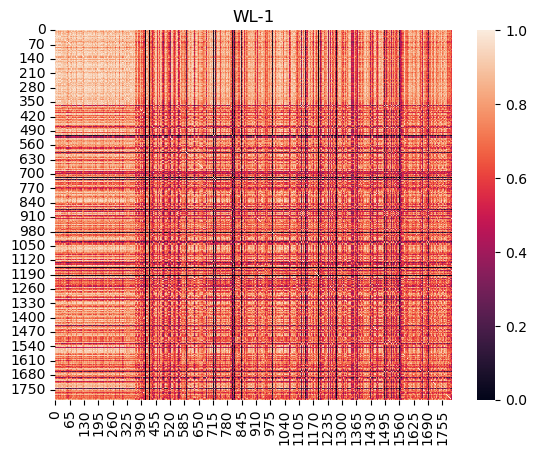

In [7]:
plot_WL(G_train_adj, 1)

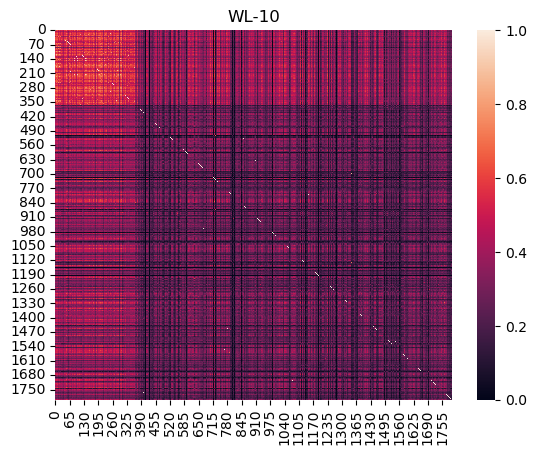

In [39]:
plot_WL(G_train_adj, 10)

In [54]:
def plot_GS(G, k_num = 4):
    wl_kernel = GraphletSampling(normalize=True, k=k_num)
    K = wl_kernel.fit_transform(G)
    print('Done fitting')
    print('Start plotting')
    # plt.figure(figsize=(14,12))
    sns.heatmap(K)
    plt.title(f'GS-{k_num}')
    plt.show()


Done fitting
Start plotting


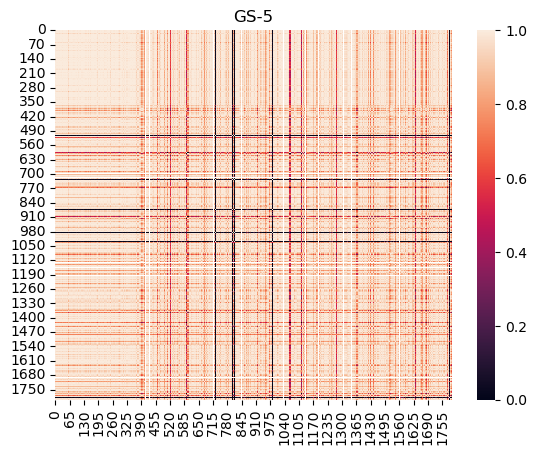

In [58]:
plot_GS(G_train_adj, 5)

Done fitting
Start plotting


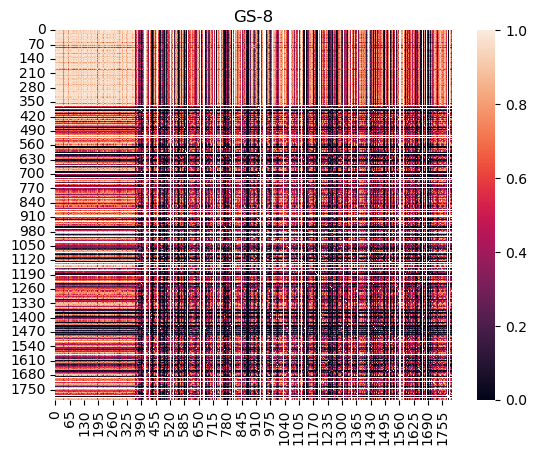

In [59]:
plot_GS(G_train_adj, 8)

In [63]:
def plot_SP(G):
    wl_kernel = ShortestPath(normalize=True, algorithm_type="floyd_warshall")
    K = wl_kernel.fit_transform(G)
    print('Done fitting')
    print('Start plotting')
    # plt.figure(figsize=(14,12))
    sns.heatmap(K)
    plt.title(f'SP')
    plt.show()


Done fitting
Start plotting


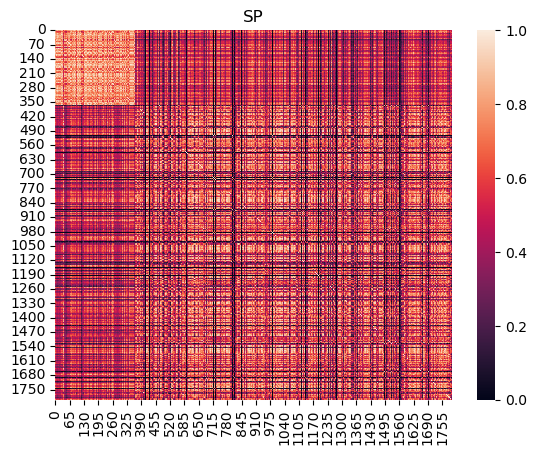

In [64]:
plot_SP(G_train_adj)

In [65]:
def plot_RW(G, lambda_value = 0.1):
    wl_kernel = RandomWalk(lamda=lambda_value, normalize=True, kernel_type="exponential")
    K = wl_kernel.fit_transform(G)
    print('Done fitting')
    print('Start plotting')
    # plt.figure(figsize=(14,12))
    sns.heatmap(K)
    plt.title(f'RW-{lambda_value}')
    plt.show()


In [69]:
plot_RW(G_train_adj, 0.1)

In [38]:
import scipy as sp
import ot
from tqdm import tqdm

In [59]:
graph_indi = np.loadtxt('./data/AIDS/AIDS_graph_indicator.txt', dtype = int, delimiter = ',')
graph_labels = np.loadtxt('./data/AIDS/AIDS_graph_labels.txt', dtype = int)
node_attr = np.loadtxt('./data/AIDS/AIDS_node_attributes.txt', delimiter = ',')

In [17]:
# idx = np.unique(graph_indi)
xs = node_attr[np.argwhere(graph_indi == 1)]
xt = node_attr[np.argwhere(graph_indi == 2)]
xs = np.squeeze(xs, axis=(1,))
xt = np.squeeze(xt, axis=(1,))
xs.shape, xt.shape

((47, 4), (11, 4))

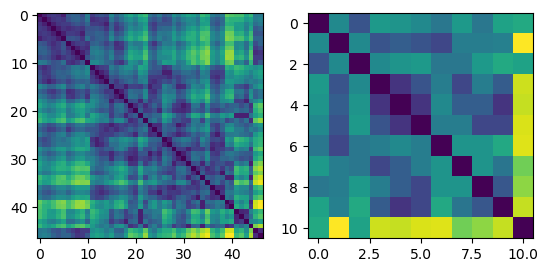

In [19]:
C1 = sp.spatial.distance.cdist(xs, xs)
C2 = sp.spatial.distance.cdist(xt, xt)

C1 /= C1.max()
C2 /= C2.max()

plt.figure()
plt.subplot(121)
plt.imshow(C1)
plt.subplot(122)
plt.imshow(C2)
plt.show()

In [29]:
p = ot.unif(len(xs))
q = ot.unif(len(xt))

gw0, log0 = ot.gromov.gromov_wasserstein(
    C1, C2, p, q, 'square_loss', verbose=False, log=True)

gw, log = ot.gromov.entropic_gromov_wasserstein(
    C1, C2, p, q, 'square_loss', epsilon=5e-4, log=True, verbose=True)

print('Gromov-Wasserstein distances: ' + str(log0['gw_dist']))
print('Entropic Gromov-Wasserstein distances: ' + str(log['gw_dist']))

It.  |Err         
-------------------
    0|8.570252e-02|
   10|5.390835e-03|
   20|9.558095e-15|
Gromov-Wasserstein distances: 0.045130260951497844
Entropic Gromov-Wasserstein distances: 0.04137580317570028


In [37]:
xs = node_attr[np.argwhere(graph_indi == 1).ravel()]
xs.shape

(47, 4)

In [72]:
graph_0 = np.argwhere(graph_labels == 0).ravel() + 1
graph_1 = np.argwhere(graph_labels == 1).ravel() + 1

In [91]:
n = 40
m = 40
tmp_graphs = np.row_stack([graph_0[:n], graph_1[:m]]).ravel()
tmp_graphs 

array([  1,   5,   9,  11,  15,  19,  28,  36,  43,  44,  57,  59,  64,
        69,  77,  99, 112, 114, 121, 126, 132, 138, 140, 142, 146, 151,
       156, 160, 163, 167, 168, 172, 173, 174, 185, 188, 189, 195, 204,
       206,   2,   3,   4,   6,   7,   8,  10,  12,  13,  14,  16,  17,
        18,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,  32,
        33,  34,  35,  37,  38,  39,  40,  41,  42,  45,  46,  47,  48,
        49,  50])

In [92]:
GW_dist_list = []
for ii in tqdm(range(n+m)):
    i = tmp_graphs[ii]
    for jj in range(ii+1, n+m):
        j = tmp_graphs[jj]
        xs = node_attr[np.argwhere(graph_indi == i).ravel()]
        xt = node_attr[np.argwhere(graph_indi == j).ravel()]

        p = ot.unif(len(xs))
        q = ot.unif(len(xt))

        C1 = sp.spatial.distance.cdist(xs, xs)
        C2 = sp.spatial.distance.cdist(xt, xt)
        C1 /= C1.max()
        C2 /= C2.max()

        gw0, log0 = ot.gromov.gromov_wasserstein(
            C1, C2, p, q, 'square_loss', verbose=False, log=True)
        # print(f'{i}-{j} Gromov-Wasserstein distances: ' + str(log0['gw_dist']))
        GW_dist_list.append(log0['gw_dist'])

100%|██████████| 80/80 [00:07<00:00, 11.31it/s]


In [93]:
KK = sp.spatial.distance.squareform(GW_dist_list)

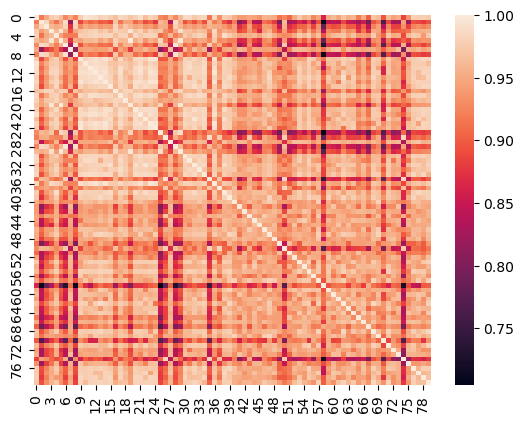

In [97]:
sns.heatmap((1-KK))
plt.show()